# The analysis of Precision-Recall Trade off using custom mode of CorrectionGLM

In [49]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import seaborn as sns
import numpy as np

## Functions for plotting

In [50]:
def from_data_frames_to_dots(dataframes: Dict[str, Tuple[pd.DataFrame, pd.DataFrame]]):
    # keep threshold: precision dataframe, recall dataframe
    dots = {'Precision': [], 'Recall': [], 'KEEP': [], 'ERROR': [], 'INSERT': []}
    for keep_th in dataframes:
        # print(dataframes)
        precision_df = dataframes[keep_th][0]
        recall_df = dataframes[keep_th][1]
        columns = list(precision_df.columns)
        assert columns == list(recall_df.columns)
        assert columns[0] == 'INSERT'
        for (i1, precision_item), (i2, recall_item) in zip(precision_df.iterrows(), recall_df.iterrows()):
            for column in columns[1:]:
                precision = precision_item[column]
                recall = recall_item[column]
                dots['Precision'].append(precision*100)
                dots['Recall'].append(recall*100)
                dots['KEEP'].append(keep_th)
                dots['ERROR'].append(column)
                assert precision_item[columns[0]] == recall_item[columns[0]]
                dots['INSERT'].append(precision_item[columns[0]])
    return dots


def f_05(prec, rec):
    return 1.25*prec*rec/(0.25*prec + rec)

def get_all_dataframe(directory):
    dataframes = {}
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            base_name = file.replace('.csv', '')
            _, keep_threshold, metric = base_name.split('_', 2)
            if keep_threshold not in dataframes:
                dataframes[keep_threshold] = {}
            dataframes[keep_threshold][metric] = pd.read_csv(os.path.join(directory, file))
    return dataframes


def get_precision_recall_dataframe(directory):
    all_dataframes = get_all_dataframe(directory)
    pr_dataframes = {}
    for keep_th in all_dataframes:
        pr_dataframes[keep_th] = (all_dataframes[keep_th]['p'], all_dataframes[keep_th]['r'])
    return pr_dataframes


def get_all_keep_results(result_dir):
    valid_dirs = []
    for name in os.listdir(result_dir):
        if name.startswith('keep_threshold'):
            valid_dirs.append(os.path.join(result_dir, name))
    
    results = {}
    for dir in valid_dirs:
        keep_th = eval(dir.split('_')[-1])
        if keep_th == 0.0:
            continue
        infer_res_dir = os.path.join(dir, 'test')
        file_name = None
        for file in os.listdir(infer_res_dir):
            if file.endswith('metrics.txt'):
                file_name = os.path.join(infer_res_dir, file)
        metrics_lines = open(file_name).readlines()
        precision_name, _, precision = metrics_lines[0].strip().split()
        recall_name, _, recall = metrics_lines[1].strip().split()
        f_05_name, _, f_05 = metrics_lines[2].strip().split()
        precision, recall, f_05 = eval(precision)*100, eval(recall)*100, eval(f_05)*100
        results[keep_th] = [precision, recall, f_05]
    
    return results


def get_keep_dots(keep_results):
    dots = {'Precision': [], 'Recall': [], 'KEEP': [], 'ERROR': [], 'INSERT': []}
    for key in keep_results:
        dots['KEEP'].append(key)
        dots['INSERT'].append(0)
        dots['ERROR'].append(0)
        dots['Precision'].append(keep_results[key][0])
        dots['Recall'].append(keep_results[key][1])
    return dots


def merge_dots(dots_list):
    new_dots = {'Precision': [], 'Recall': [], 'KEEP': [], 'ERROR': [], 'INSERT': []}
    for dots in dots_list:
        for key in new_dots:
            new_dots[key] += dots[key]
    return new_dots

In [51]:
MUL=100

In [52]:

def draw_keep_curve(keep_results):
    all_res = []
    
    for key in keep_results:
        all_res.append([key, keep_results[key][0], keep_results[key][1], keep_results[key][2]])
    all_res = sorted(all_res, key=lambda item:item[0])
    keep = [item[0] for item in all_res]
    prec = [item[1] for item in all_res]
    rec = [item[2] for item in all_res]
    f05 = [round(item[3],1) for item in all_res]

    max_index = np.argmax(f05)

    # sns.set(style='whitegrid')
    # plt.axis([0, 0.5, 0, 1])
    plt.xlim(0, 0.5)
    plt.ylim(0, MUL*1.08)
    plt.tick_params(direction='out', length=6, width=2, colors='k')
    
    plt.xlabel("KEEP operation threshold")
    plt.ylabel("Value")

    
    plt.plot(keep, f05, label='F0.5', color='k')
    plt.plot(keep, prec, label='Precision', linestyle='--')
    plt.plot(keep, rec, label='Recall', linestyle='-.')

    plt.scatter(x=keep[max_index], y=f05[max_index], marker='D')
    plt.plot([keep[max_index], keep[max_index]], [0, f05[max_index]], linestyle='dotted')


    # plt.title('Control of KEEP threshold')
    plt.legend(loc='upper right', fontsize=16)

    # plt.show()



def heatmap(single_dataframe: pd.DataFrame):
    single_dataframe.index = single_dataframe['INSERT'].to_list()
    df = single_dataframe.drop(columns=['INSERT'])
    # df = np.log(df)
    df = df.applymap(lambda x: max(MUL*x, MUL*0.6))
    plt.tick_params(direction='out', length=6, width=2, colors='k')    
    sns.heatmap(data=df, annot=False, fmt='.4g', cmap='Reds', linewidths=0.1, linecolor='white')
    plt.xlabel("ERROR Lower-Bound")
    plt.ylabel("INSERT Lower-Bound")
    plt.title("Control of lower bound of ERROR and INSERT")
    plt.show()



def pre_rec_scatter(axis: List[float], dots, 
                    curve_points: List[List[float]],
                    f_05_lines: List[float],
                    frontier_config: Dict[str, float],
                    marked_dots: List[Tuple[float, float, str]],
    ):
    # keep threshold: precision dataframe, recall dataframe
    plt.axis(axis)
    plt.tick_params(direction='out', length=6, width=2, colors='k')

    # equal lines
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    step = MUL*0.002
    x = np.arange(x_min, x_max+step/2, step=step)
    y = np.arange(y_min, y_max+step/2, step=step)
    x_mesh, y_mesh = np.meshgrid(x, y)
    f_mesh = f_05(x_mesh, y_mesh)
    if f_05_lines:
        contour = plt.contour(x_mesh, y_mesh, f_mesh, f_05_lines, colors='k')
        plt.clabel(contour, colors='k')
    else:
        contour_color = plt.contourf(x_mesh, y_mesh, f_mesh, 10, cmap='hot')
        contour = plt.contour(x_mesh, y_mesh, f_mesh, 4, colors='k')
        plt.clabel(contour, colors='k')
        plt.colorbar(contour_color)

    # colors, scatter
    colors = []
    for k, e, i in zip(dots['KEEP'], dots['ERROR'], dots['INSERT']):
        colors.append((k,e,i,1))
    # sns.scatterplot(data=dots, x='Precision', y='Recall', hue='Group')
    # plt.scatter(dots['Precision'], dots['Recall'], c=[p*r for p,r in zip(dots['Precision'], dots['Recall'])])
    plt.scatter(dots['Precision'], dots['Recall'], c=colors, marker='o', edgecolors='w')
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    # plt.title("Precision-Recall Trade-off by Ctrl")
    # plt.bar_label("F0.5")

    # 边界曲线拟合
    # 先按0.1为间隔找F0.5值最大的点
    # list item (x, y, F0.5)
    dots_pos = [(p,r) for p,r in zip(dots['Precision'], dots['Recall'])]
    # sort by x
    dots_pos = sorted(dots_pos, key=lambda pos:pos[0])
    dots_f_05 = [f_05(p, r) for p, r in dots_pos]
    # interval
    pre_min, pre_max = dots_pos[0][0], dots_pos[-1][0]
    interval_num = frontier_config['interval_num']
    interval_length = (pre_max - pre_min)/interval_num
    dots_selected_idx = [None]*interval_num
    iter_idx = 0
    for i, interval_start in enumerate(np.arange(pre_min, pre_max-0.001, interval_length)):
        interval_end = interval_start + interval_length
        last_iter_idx = iter_idx
        while iter_idx < len(dots_pos) and dots_pos[iter_idx][0] <= interval_end:
            iter_idx += 1
        if last_iter_idx < iter_idx:
            span_dots_y = [dots_pos[idx][1] for idx in range(last_iter_idx, iter_idx)]
            span_dots_f_05 = dots_f_05[last_iter_idx: iter_idx]
            if frontier_config['frontier_key'] == 'y':
                dots_selected_idx[i] = last_iter_idx + np.argmax(span_dots_y)
            else:
                dots_selected_idx[i] = last_iter_idx + np.argmax(span_dots_f_05)
    # dots selected
    dots_selected = []
    for idx in dots_selected_idx:
        if idx != None:
            dots_selected.append(dots_pos[idx])
    # 根据这些点拟合曲线
    if curve_points == []:
        poly_model = np.polyfit(
            [item[0] for item in dots_selected], 
            [item[1] for item in dots_selected],
            deg=frontier_config['poly'],
        )
    else:
        poly_model = np.polyfit(
            [item[0] for item in curve_points], 
            [item[1] for item in curve_points],
            deg=frontier_config['poly'],
        )
    y_fit = np.polyval(poly_model, x)
    plt.plot(x, y_fit, linestyle='--', color='w')

    for marked_dot in marked_dots:
        mark_x, mark_y, mark = marked_dot
        plt.text(mark_x, mark_y, mark, fontsize=20, color='w')
    # plt.show()




## Draw three figs

In [53]:
keep_res_bea = get_all_keep_results('../results_main/correctionglm-bea_dev-custom-20240128-1822')
DPI = 200
matplotlib.rcParams["font.size"] = 20

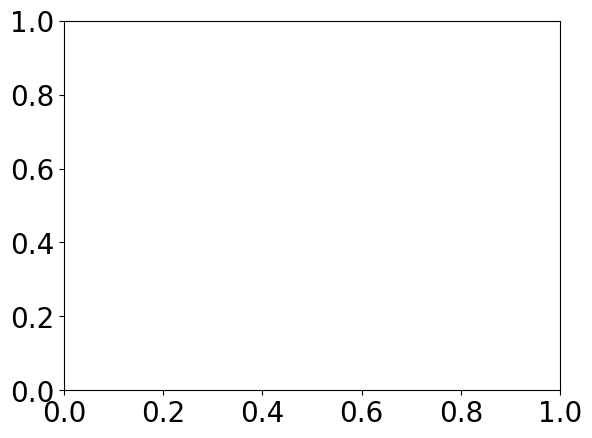

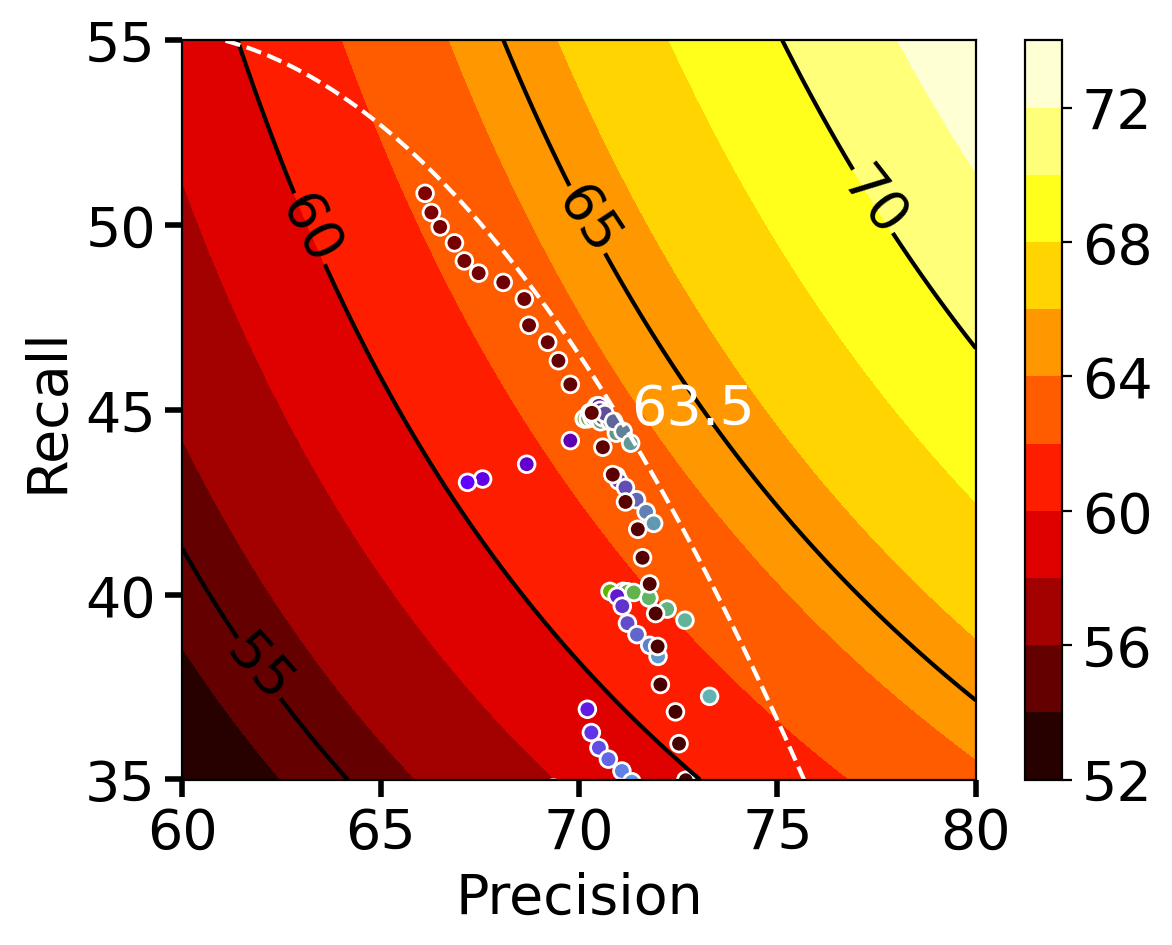

In [54]:
plt.cla()
plt.figure(dpi=DPI)
dataframes = get_precision_recall_dataframe('../results_main/correctionglm-bea_dev-custom-20240130-0039'), 
dots1 = from_data_frames_to_dots(dataframes[0])
dots2 = get_keep_dots(keep_res_bea)
pre_rec_scatter(
    axis=[60, 80, 35, 55], 
    dots=merge_dots([dots1, dots2]),
    curve_points=[[77, 30], [75, 37], [74, 41], [72, 43], [65, 51], [60, 56], ],
    f_05_lines=[],
    frontier_config={'interval_num': 10, 'frontier_key': 'f0.5', 'poly': 2},
    marked_dots=[[71.3, 44.6, '63.5']]
)

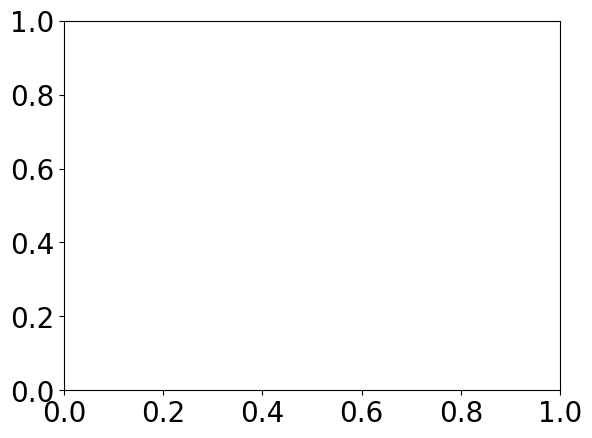

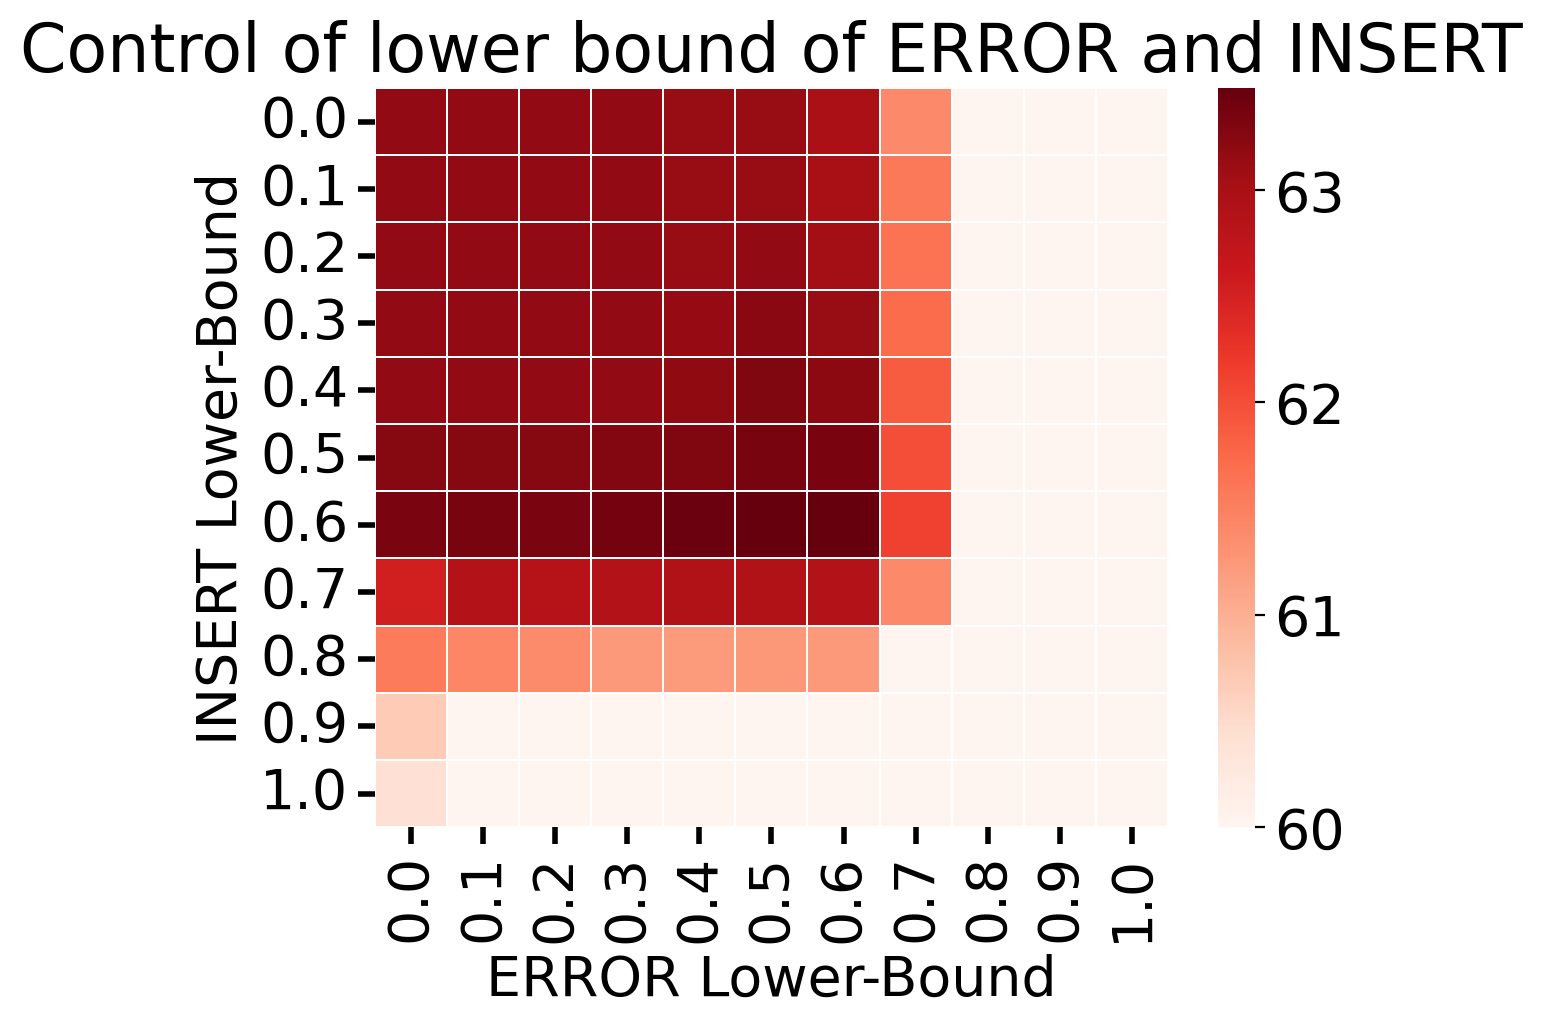

In [55]:
plt.cla()
plt.figure(dpi=DPI)
heatmap(pd.read_csv('../results_main/correctionglm-bea_dev-custom-20240130-0039/keep_0.38_f_05.csv'))

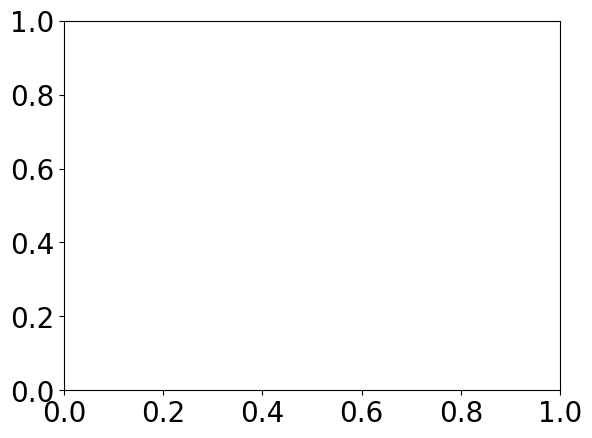

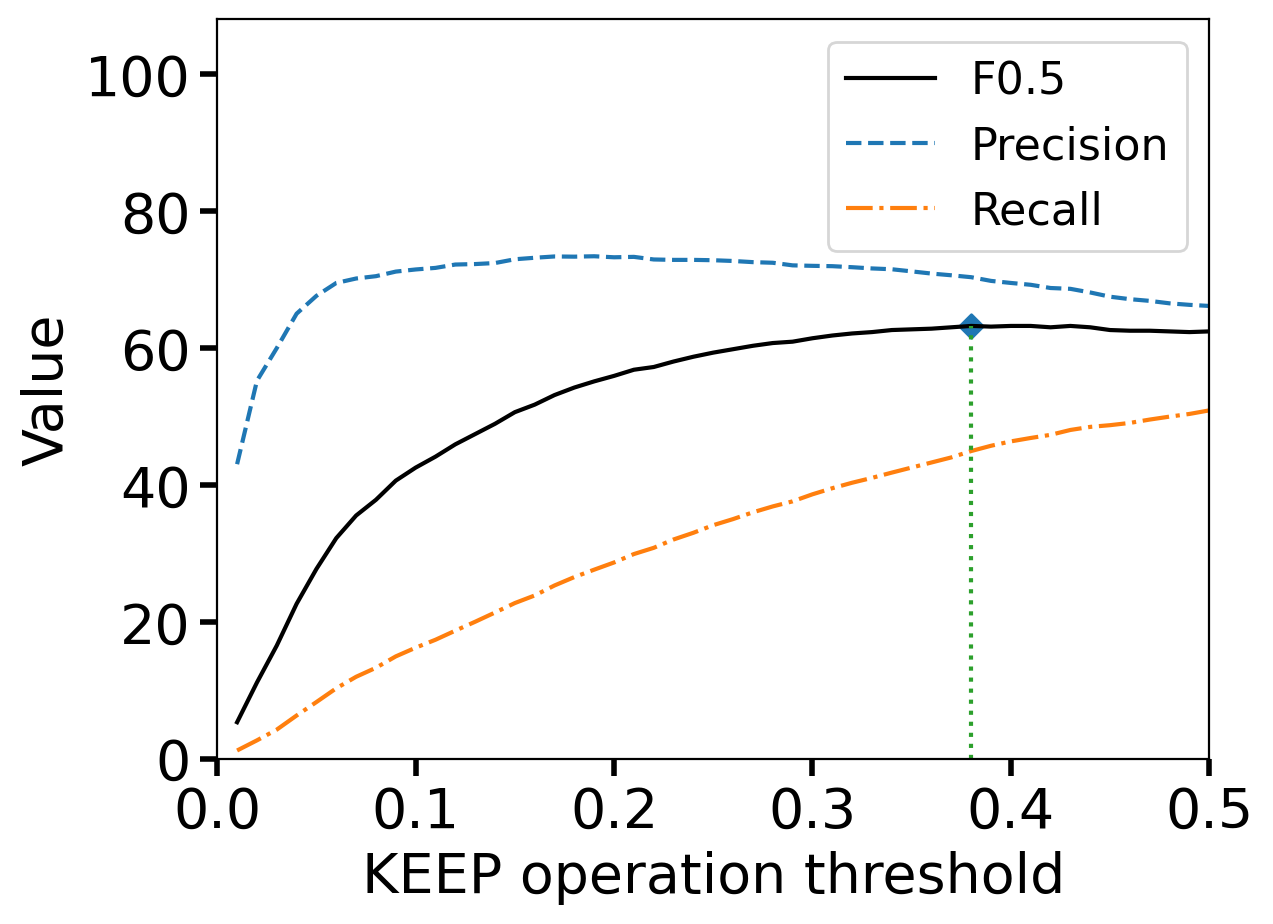

In [56]:
plt.cla()
plt.figure(dpi=DPI)
draw_keep_curve(keep_results=keep_res_bea)